In [1]:
# Imports
import sf_quant.data as sfd
import sf_quant.optimizer as sfo
import sf_quant.backtester as sfb
import sf_quant.performance as sfp
import polars as pl
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import numpy as np

/home/nchasem/projects/sf-quant-labs/.venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-01 15:33:38,640	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
import polars as pl

# =========================================================
# 1) CRSP Pricing (daily)
# =========================================================
crsp_pricing = pl.read_csv(
    r"/home/nchasem/projects/sf-quant-labs/labs/crsp_pricing.csv",
    infer_schema_length=10000,
    schema_overrides={"CUSIP": pl.Utf8, "NCUSIP": pl.Utf8}
).with_columns([
    pl.col("date").str.strptime(pl.Date, format="%Y-%m-%d", strict=False),
    pl.col("PRC").abs().alias("PRC")
])
print("\n[CRSP_PRICING] columns:", crsp_pricing.columns)

# =========================================================
# 2) CRSP Delistings (daily)
# =========================================================
crsp_delisting = pl.read_csv(
    r"/home/nchasem/projects/sf-quant-labs/labs/crsp_delisting.csv",
    infer_schema_length=10000,
    schema_overrides={"CUSIP": pl.Utf8, "NCUSIP": pl.Utf8}
).with_columns(
    pl.col("date").str.strptime(pl.Date, format="%Y-%m-%d", strict=False)
)
print("\n[CRSP_DELIST] columns:", crsp_delisting.columns)

# =========================================================
# 3) Merge CRSP Pricing + Delistings (daily, PERMNO+date)
#    (avoid CUSIP in the key)
# =========================================================
crsp_daily = crsp_pricing.join(
    crsp_delisting.select(["PERMNO","date","DLRET"]),
    on=["PERMNO","date"], how="left"
)

# Cast to float in a separate step (new columns)
crsp_daily = crsp_daily.with_columns([
    pl.col("RET").cast(pl.Float64, strict=False).alias("RET_F"),
    pl.col("DLRET").cast(pl.Float64, strict=False).alias("DLRET_F"),
])

# Combined return (daily)
crsp_daily = crsp_daily.with_columns(
    ((1 + pl.col("RET_F").fill_null(0.0)) * (1 + pl.col("DLRET_F").fill_null(0.0)) - 1.0)
    .alias("RET_COMB")
)
print("\n[CRSP_DAILY] columns:", crsp_daily.columns)

# =========================================================
# 4) Roll CRSP Daily -> Monthly (month-end key)
#    (compounded monthly return; month-end PRC/SHROUT; ME)
# =========================================================
crsp_m = (
    crsp_daily
    .with_columns(pl.col("date").dt.month_end().alias("mend"))
    .group_by(["PERMNO","mend"])
    .agg([
        (pl.col("RET_COMB").fill_null(0.0).add(1).product() - 1).alias("RET_M"),
        pl.col("PRC").last().alias("PRC_ME"),
        pl.col("SHROUT").last().alias("SHROUT_ME"),
    ])
    .with_columns((pl.col("PRC_ME") * pl.col("SHROUT_ME") * 1000.0).alias("ME"))
    .rename({"mend": "date"})
    .sort(["PERMNO","date"])
)
print("\n[CRSP_MONTHLY] columns:", crsp_m.columns)

# =========================================================
# 5) S&P / Market Series (align to month-end; no join yet)
# =========================================================
sp500 = pl.read_csv(
    r"/home/nchasem/projects/sf-quant-labs/labs/sp500.csv",
    infer_schema_length=10000
)

# Parse date
sp500 = sp500.with_columns(
    pl.col("caldt").str.strptime(pl.Date, format="%Y-%m-%d", strict=False)
)

# Month-end key
sp500 = sp500.with_columns(
    pl.col("caldt").dt.month_end().alias("date")
)

print("\n[SP500_RAW] columns:", sp500.columns)

# =========================================================
# 6) Compustat (raw; no attach yet)
# =========================================================
compustat = pl.read_csv(
    r'/home/nchasem/projects/sf-quant-labs/labs/compustat_updated.csv',
    infer_schema_length=10000,
    schema_overrides={"GVKEY": pl.Utf8, "CUSIP": pl.Utf8, "TIC": pl.Utf8, "CONM": pl.Utf8}
).with_columns(
    pl.col("datadate").str.strptime(pl.Date, format="%Y-%m-%d", strict=False)
)
print("\n[COMPUSTAT_RAW] columns:", compustat.columns)

# =========================================================
# 7) CRSP–Compustat Link (CCM) — cleaned but unused yet
#    ["gvkey","LINKTYPE","PERMNO","LPERMCO","LINKDT","LINKENDDT","tic","cusip"])
# =========================================================
link = pl.read_csv(
    r'/home/nchasem/projects/sf-quant-labs/labs/link.csv',
    infer_schema_length=10000
).rename({'LPERMNO': 'PERMNO', 'GVKEY': 'gvkey'}).with_columns([
    pl.col("LINKDT").str.strptime(pl.Date, strict=False),
    pl.col("LINKENDDT").str.strptime(pl.Date, strict=False),
]).with_columns(
    pl.when(pl.col("LINKENDDT").is_null())
      .then(pl.date(2099,12,31))
      .otherwise(pl.col("LINKENDDT"))
      .alias("LINKENDDT")
).filter(
    pl.col("LINKTYPE").is_in(["LU","LC"])               # <-- no LINKPRIM in your file
).select([
    "PERMNO","gvkey","LINKDT","LINKENDDT","LINKTYPE","tic","cusip"
])

print("\n[CCM_LINK] columns:", link.columns)


[CRSP_PRICING] columns: ['PERMNO', 'date', 'SHRCD', 'EXCHCD', 'CUSIP', 'BIDLO', 'ASKHI', 'PRC', 'VOL', 'RET', 'SHROUT', 'RETX']

[CRSP_DELIST] columns: ['PERMNO', 'date', 'NCUSIP', 'TICKER', 'CUSIP', 'DLAMT', 'DLPDT', 'DLSTCD', 'DLRETX', 'DLPRC', 'DLRET']

[CRSP_DAILY] columns: ['PERMNO', 'date', 'SHRCD', 'EXCHCD', 'CUSIP', 'BIDLO', 'ASKHI', 'PRC', 'VOL', 'RET', 'SHROUT', 'RETX', 'DLRET', 'RET_F', 'DLRET_F', 'RET_COMB']

[CRSP_MONTHLY] columns: ['PERMNO', 'date', 'RET_M', 'PRC_ME', 'SHROUT_ME', 'ME']

[SP500_RAW] columns: ['caldt', 'totval', 'totcnt', 'usdval', 'spindx', 'sprtrn', 'date']

[COMPUSTAT_RAW] columns: ['costat', 'curcdq', 'datafmt', 'indfmt', 'consol', 'gvkey', 'datadate', 'cusip', 'atq', 'cheq', 'ltq', 'niq', 'pstkrq', 'seqq', 'txditcq']

[CCM_LINK] columns: ['PERMNO', 'gvkey', 'LINKDT', 'LINKENDDT', 'LINKTYPE', 'tic', 'cusip']


In [3]:
# =========================================================
# 8) Add Market Return to CRSP Monthly (no factors yet)
#     - Use sprtrn from SP500 as monthly market return
# =========================================================
crsp_m = crsp_m.join(
    sp500.select(["date", "sprtrn"]).rename({"sprtrn": "MKT_M"}),
    on="date", how="left"
)
print("\n[CRSP_MONTHLY+MKT] columns:", crsp_m.columns)

# =========================================================
# 9) Build PERMNO×date → GVKEY mapping via CCM link window
#     - This gives us the keys to attach accounting later
# =========================================================
panel_keys = (
    crsp_m.join(link.select(["PERMNO","gvkey","LINKDT","LINKENDDT"]),
                on="PERMNO", how="left")
          .filter(
              (pl.col("date") >= pl.col("LINKDT")) &
              (pl.col("date") <= pl.col("LINKENDDT"))
          )
          .select([
              "PERMNO","date","gvkey",
              "RET_M","PRC_ME","SHROUT_ME","ME","MKT_M"
          ])
          .sort(["PERMNO","date"])
)
print("\n[PANEL_KEYS] columns:", panel_keys.columns)


[CRSP_MONTHLY+MKT] columns: ['PERMNO', 'date', 'RET_M', 'PRC_ME', 'SHROUT_ME', 'ME', 'MKT_M']

[PANEL_KEYS] columns: ['PERMNO', 'date', 'gvkey', 'RET_M', 'PRC_ME', 'SHROUT_ME', 'ME', 'MKT_M']


In [4]:
# =========================================================
# 10) COMPUSTAT — add availability date (no attach yet)
#      using the columns you actually have:
#      ['gvkey','datadate','cusip','atq','cheq','ltq','niq','pstkrq','seqq','txditcq']
# =========================================================
comp_prep = (
    compustat
    .select([
        "gvkey","datadate","cusip",
        "atq","cheq","ltq","niq","pstkrq","seqq","txditcq"
    ])
    .with_columns(
        pl.col("datadate").dt.offset_by("6mo").alias("avail_date")
    )
)

print("\n[COMPUSTAT_PREP] columns:", comp_prep.columns)


[COMPUSTAT_PREP] columns: ['gvkey', 'datadate', 'cusip', 'atq', 'cheq', 'ltq', 'niq', 'pstkrq', 'seqq', 'txditcq', 'avail_date']


In [5]:
# =========================================================
# 11) Attach accounting to monthly keys (6-mo availability)
#     (Lazy + Streaming to avoid kernel crash)
# =========================================================
panel = (
    panel_keys.lazy()
    .join(comp_prep.lazy(), on="gvkey", how="left")
    # only keep accounting rows available as of this month-end
    .filter(pl.col("avail_date") <= pl.col("date"))
    # mark the latest datadate per (PERMNO,date)
    .with_columns(
        pl.col("datadate").max().over(["PERMNO","date"]).alias("_max_dd")
    )
    .filter(pl.col("datadate") == pl.col("_max_dd"))
    .drop("_max_dd")
    # collapse duplicates (just in case)
    .group_by(["PERMNO","date"])
    .agg([
        pl.col("gvkey").first(),
        pl.col("RET_M").first(),
        pl.col("PRC_ME").first(),
        pl.col("SHROUT_ME").first(),
        pl.col("ME").first(),
        pl.col("MKT_M").first(),
        pl.col("datadate").first(),
        pl.col("cusip").first(),
        pl.col("atq").first(),
        pl.col("cheq").first(),
        pl.col("ltq").first(),
        pl.col("niq").first(),
        pl.col("pstkrq").first(),
        pl.col("seqq").first(),
        pl.col("txditcq").first(),
    ])
    .sort(["PERMNO","date"])
    .collect(engine="streaming")
)

print("\n[PANEL] columns:", panel.columns)


[PANEL] columns: ['PERMNO', 'date', 'gvkey', 'RET_M', 'PRC_ME', 'SHROUT_ME', 'ME', 'MKT_M', 'datadate', 'cusip', 'atq', 'cheq', 'ltq', 'niq', 'pstkrq', 'seqq', 'txditcq']


## 8 CHS PREDICTORS

In [6]:
# =========================================================
# 12) Structural bases (units fix inside formulas)
#      - MTA  = ME + LTQ_usd
#      - BE_raw = (SEQQ_usd + TXDITCQ_usd - PSTKRQ_usd)
# =========================================================
panel = panel.with_columns([
    (pl.col("ME") + pl.col("ltq") * 1_000_000).alias("MTA"),
    (pl.col("seqq") * 1_000_000
     + pl.col("txditcq").fill_null(0.0) * 1_000_000
     - pl.col("pstkrq").fill_null(0.0) * 1_000_000).alias("BE_raw"),
])

In [7]:
# ---- 13a) Make BE first (guarding <= 0) ----
panel = panel.with_columns(
    pl.when(pl.col("BE_raw") <= 0).then(pl.lit(1e-6)).otherwise(pl.col("BE_raw")).alias("BE")
)

# ---- 13b) Now the simple ratios (units-consistent) ----
panel = panel.with_columns([
    # use dollars in the numerators to match MTA (which is in dollars)
    (pl.col("ltq")  * 1_000_000 / pl.col("MTA")).alias("TLMTA"),
    (pl.col("cheq") * 1_000_000 / pl.col("MTA")).alias("CASHMTA"),

    (pl.col("ME") / pl.col("BE")).alias("MB"),
    pl.min_horizontal(pl.col("PRC_ME"), pl.lit(15.0)).log().alias("PRICE"),
])

In [8]:
# =========================================================
# 14) Cross-section + rolling returns
#      - RSIZE     = log( ME / sum(ME)_month )
#      - EXRET     = RET_M - MKT_M
#      - EXRETAVG  = 12-month rolling mean of EXRET (per PERMNO)
# =========================================================

# sort once for rolling ops
panel = panel.sort(["PERMNO", "date"])

# monthly total market cap, then RSIZE
panel = (
    panel
    .join(
        panel.group_by("date").agg(pl.col("ME").sum().alias("ME_mkt")),
        on="date", how="left"
    )
    .with_columns(
        (pl.col("ME") / pl.col("ME_mkt")).log().alias("RSIZE"),
        (pl.col("RET_M") - pl.col("MKT_M")).alias("EXRET"),
    )
    .with_columns(
        pl.col("EXRET").rolling_mean(window_size=12).over("PERMNO").alias("EXRETAVG")
    )
)

In [9]:
# =========================================================
# 15) SIGMA (annualized 3-mo daily std) using RET_COMB
# =========================================================

crsp_sig = (
    crsp_daily
    .sort(["PERMNO","date"])
    .with_columns(
        pl.col("RET_COMB").rolling_std(window_size=63).over("PERMNO").alias("SIGMA_3M")
    )
    # annualize the 3-month rolling daily std
    .with_columns((pl.col("SIGMA_3M") * (252.0 ** 0.5)).alias("SIGMA_3M"))
    .with_columns(pl.col("date").dt.month_end().alias("date"))
)

# collapse to month-end: last non-null
sigma_m = (
    crsp_sig
    .group_by(["PERMNO","date"])
    .agg(pl.col("SIGMA_3M").drop_nulls().last().alias("SIGMA"))
)

# same-month cross-sectional mean imputation (optional but CHS-like)
sigma_cs = sigma_m.group_by("date").agg(pl.col("SIGMA").mean().alias("SIGMA_CS"))
sigma_m = (
    sigma_m.join(sigma_cs, on="date", how="left")
           .with_columns(pl.coalesce([pl.col("SIGMA"), pl.col("SIGMA_CS")]).alias("SIGMA"))
           .drop("SIGMA_CS")
)

# join back to monthly panel
panel = panel.join(sigma_m, on=["PERMNO","date"], how="left")

In [10]:
# =========================================================
# 16b) NIMTAAVG with CHS geometric weights (λ = 2/13)
# =========================================================

# λ = 2/13

# # make sure panel is sorted
# panel = panel.sort(["PERMNO","date"])

# # compute lagged NIMTA values for 1..12 months back
# for k in range(1, 13):
#     panel = panel.with_columns(
#         pl.col("NIMTA").shift(k).over("PERMNO").alias(f"NIMTA_lag{k}")
#     )

# # apply weights (geometric decay)
# weights = [(1-λ)**(k-1) * λ for k in range(1, 13)]
# weight_sum = sum(weights)  # should be ≈1.0, but normalize anyway
# weights = [w/weight_sum for w in weights]

# exprs = [pl.col(f"NIMTA_lag{k}") * weights[k-1] for k in range(1, 13)]

# panel = panel.with_columns(
#     sum(exprs).alias("NIMTAAVG")
# )

# # drop intermediate lag columns to save memory since theyre no longer useful
# panel = panel.drop([f"NIMTA_lag{k}" for k in range(1, 13)])

# EQUAL WEIGHTS
# =========================================================
# 16b-alt) NIMTAAVG with equal weights (12-mo simple avg)
# =========================================================

# =========================================================
# NIMTA and NIMTAAVG
#      - NIMTA     = NIQ / MTA
#      - NIMTAAVG  = 12-month rolling mean (per PERMNO)
# =========================================================

panel = panel.sort(["PERMNO","date"])

# NIMTA uses niq in dollars over MTA (already in dollars now)
panel = panel.with_columns(
    (pl.col("niq") * 1_000_000 / pl.col("MTA")).alias("NIMTA")
)

# 12-month average of *past* NIMTA
panel = panel.with_columns(
    pl.col("NIMTA").shift(1).rolling_mean(12).over("PERMNO").alias("NIMTAAVG")
)

## FAILURE INDICATOR

In [11]:
# =========================================================
# 17) Failure-in-12M indicator (Y) from CRSP delist codes
#     - Use CHS failure codes
#     - For each failure event, flag the prior 12 months as Y=1
# =========================================================

# 17a) select failure delist events
fail_codes = [500] + list(range(550, 586)) + [587, 589]  # CHS-style failure set

fail_events = (
    crsp_delisting
    .select(["PERMNO", "date", "DLSTCD"])
    .with_columns(pl.col("DLSTCD").cast(pl.Int64, strict=False))
    .filter(pl.col("DLSTCD").is_in(fail_codes))
    .with_columns(pl.col("date").dt.month_end().alias("date"))  # align to month-end
    .unique(subset=["PERMNO","date"])  # one fail per PERMNO-date
)

# 17b) expand to the 12 months BEFORE each failure month
#      (so a month is labeled 1 if a failure occurs within the next 12 months)
flags = []
for k in range(1, 13):  # 1..12 months before failure
    flags.append(
        fail_events
        .with_columns(pl.col("date").dt.offset_by(f"-{k}mo").alias("date"))
        .select(["PERMNO","date"])
        .with_columns(pl.lit(1).alias("FAIL_12M"))
    )

fail_flags = pl.concat(flags).unique(subset=["PERMNO","date"])

# 17c) attach Y to the monthly panel
panel = (
    panel
    .join(fail_flags, on=["PERMNO","date"], how="left")
    .with_columns(pl.col("FAIL_12M").fill_null(0).cast(pl.Int8))
)

## Z SCORE STANDARDIZE PREDICTORS

In [12]:
# =========================================================
# 18) Z-score (standardize) CHS predictors
#      - each predictor → mean 0, std 1
# =========================================================

predictors = ["TLMTA", "CASHMTA", "MB", "PRICE",
              "RSIZE", "EXRETAVG", "SIGMA", "NIMTAAVG"]

# compute global means/stds
stats = panel.select([
    *[pl.col(c).mean().alias(f"{c}_mean") for c in predictors],
    *[pl.col(c).std().alias(f"{c}_std") for c in predictors],
]).to_dicts()[0]

# add standardized versions
for c in predictors:
    mu = stats[f"{c}_mean"]
    sd = stats[f"{c}_std"]
    panel = panel.with_columns(((pl.col(c) - mu) / sd).alias(f"{c}_z"))

In [13]:
# =========================================================
# 19) Logit + predictions, joined back by (PERMNO, date)
# =========================================================
import statsmodels.api as sm
import pandas as pd

z_cols = ["TLMTA_z","CASHMTA_z","MB_z","PRICE_z","RSIZE_z","EXRETAVG_z","SIGMA_z","NIMTAAVG_z"]

# keep keys so we can join predictions back
df_all = panel.select(["PERMNO","date","FAIL_12M", *z_cols]).to_pandas()

# training rows: need y and all predictors
mask_train = df_all[z_cols].notna().all(axis=1) & df_all["FAIL_12M"].notna()
X_train = sm.add_constant(df_all.loc[mask_train, z_cols])
y_train = df_all.loc[mask_train, "FAIL_12M"]

# fit logit
logit = sm.Logit(y_train, X_train).fit(disp=False)

# prediction rows: need all predictors (label not required)
mask_pred = df_all[z_cols].notna().all(axis=1)
X_pred = sm.add_constant(df_all.loc[mask_pred, z_cols])

pred = df_all.loc[mask_pred, ["PERMNO","date"]].copy()
pred["FAIL_PROB_12M"] = logit.predict(X_pred)

# ---- fix dtypes on keys and join back to panel ----
pred["date"] = pd.to_datetime(pred["date"]).dt.date
pred["PERMNO"] = pred["PERMNO"].astype("int64")

pred_pl = (
    pl.from_pandas(pred)
    .with_columns([
        pl.col("date").cast(pl.Date),
        pl.col("PERMNO").cast(pl.Int64),
        pl.col("FAIL_PROB_12M").cast(pl.Float64),
    ])
)

panel = (
    panel
    .with_columns([
        pl.col("date").cast(pl.Date),
        pl.col("PERMNO").cast(pl.Int64),
    ])
    .join(pred_pl, on=["PERMNO","date"], how="left")
)

print(logit.summary2())

                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: FAIL_12M         Pseudo R-squared: 0.286      
Date:               2025-10-01 15:34 AIC:              382205.5495
No. Observations:   2677022          BIC:              382320.7515
Df Model:           8                Log-Likelihood:   -1.9109e+05
Df Residuals:       2677013          LL-Null:          -2.6769e+05
Converged:          1.0000           LLR p-value:      0.0000     
No. Iterations:     11.0000          Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
const        -5.1443    0.0089  -579.5815  0.0000  -5.1617  -5.1269
TLMTA_z       0.3500    0.0050    69.7983  0.0000   0.3401   0.3598
CASHMTA_z    -0.1001    0.0041   -24.4426  0.0000  -0.1082  -0.0921
MB_z          0

## Quick Sanity Checks

In [14]:
# Peek at NIQ values directly
compustat.select([
    pl.col("niq").min().alias("niq_min"),
    pl.col("niq").max().alias("niq_max"),
    pl.col("niq").mean().alias("niq_mean"),
    pl.col("atq").min().alias("atq_min"),
    pl.col("atq").max().alias("atq_max"),
    pl.col("atq").mean().alias("atq_mean")
]).to_dicts()[0]

{'niq_min': -66047.822,
 'niq_max': 127140.0,
 'niq_mean': 32.432193712810225,
 'atq_min': -106.969,
 'atq_max': 4552482.0,
 'atq_mean': 7069.471758489149}

In [15]:
print(panel.select([
    pl.col("MTA").mean().alias("MTA_mean"),
    pl.col("BE").mean().alias("BE_mean"),
    pl.col("NIMTA").mean().alias("NIMTA_mean"),
]).to_dicts()[0])

{'MTA_mean': 9006381014.271233, 'BE_mean': 1469565905.2355149, 'NIMTA_mean': -0.007132321409576263}


In [16]:
print(panel.select([
    pl.col("FAIL_PROB_12M").min().alias("min"),
    pl.col("FAIL_PROB_12M").mean().alias("mean"),
    pl.col("FAIL_PROB_12M").median().alias("median"),
    pl.col("FAIL_PROB_12M").max().alias("max"),
]).to_dicts()[0])

{'min': 1.0832233329809418e-09, 'mean': 0.0205041273474779, 'median': 0.00445506084444324, 'max': 0.975313213479695}


## Sort and Binning

In [17]:
# =========================================================
# =========================================================
# 20) Monthly distress deciles (super simple)
# =========================================================
panel = panel.with_columns(
    pl.min_horizontal(
        (
            (pl.col("FAIL_PROB_12M").rank("ordinal").over("date")
             / pl.col("FAIL_PROB_12M").count().over("date") * 10.0
            ).ceil()
        ).cast(pl.Int8),
        pl.lit(10)
    ).alias("distress_decile")
)

# quick sanity check
print(
    panel.select([
        pl.col("distress_decile").min().alias("min_decile"),
        pl.col("distress_decile").max().alias("max_decile"),
    ]).to_dicts()[0]
)

decile_counts = (
    panel
    .filter(pl.col("distress_decile").is_not_null())
    .group_by("distress_decile")
    .agg(pl.count().alias("n"))
    .sort("distress_decile")
)
print(decile_counts)

{'min_decile': 1, 'max_decile': 10}
shape: (10, 2)
┌─────────────────┬─────────┐
│ distress_decile ┆ n       │
│ ---             ┆ ---     │
│ i32             ┆ u32     │
╞═════════════════╪═════════╡
│ 1               ┆ 267399  │
│ 2               ┆ 267725  │
│ 3               ┆ 267685  │
│ 4               ┆ 267728  │
│ 5               ┆ 267807  │
│ 6               ┆ 267596  │
│ 7               ┆ 267675  │
│ 8               ┆ 267738  │
│ 9               ┆ 267672  │
│ 10              ┆ 1329316 │
└─────────────────┴─────────┘


/tmp/ipykernel_3178266/3597948467.py:28: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("n"))


In [18]:
fail_rates = (
    panel
    .filter(pl.col("distress_decile").is_not_null())
    .group_by("distress_decile")
    .agg([
        pl.mean("FAIL_12M").alias("failure_rate"),
        pl.len().alias("n")
    ])
    .sort("distress_decile")
)

print(fail_rates)

shape: (10, 3)
┌─────────────────┬──────────────┬─────────┐
│ distress_decile ┆ failure_rate ┆ n       │
│ ---             ┆ ---          ┆ ---     │
│ i32             ┆ f64          ┆ u32     │
╞═════════════════╪══════════════╪═════════╡
│ 1               ┆ 0.000337     ┆ 267399  │
│ 2               ┆ 0.00087      ┆ 267725  │
│ 3               ┆ 0.001057     ┆ 267685  │
│ 4               ┆ 0.00183      ┆ 267728  │
│ 5               ┆ 0.002804     ┆ 267807  │
│ 6               ┆ 0.004443     ┆ 267596  │
│ 7               ┆ 0.008189     ┆ 267675  │
│ 8               ┆ 0.015523     ┆ 267738  │
│ 9               ┆ 0.035499     ┆ 267672  │
│ 10              ┆ 0.038705     ┆ 1329316 │
└─────────────────┴──────────────┴─────────┘


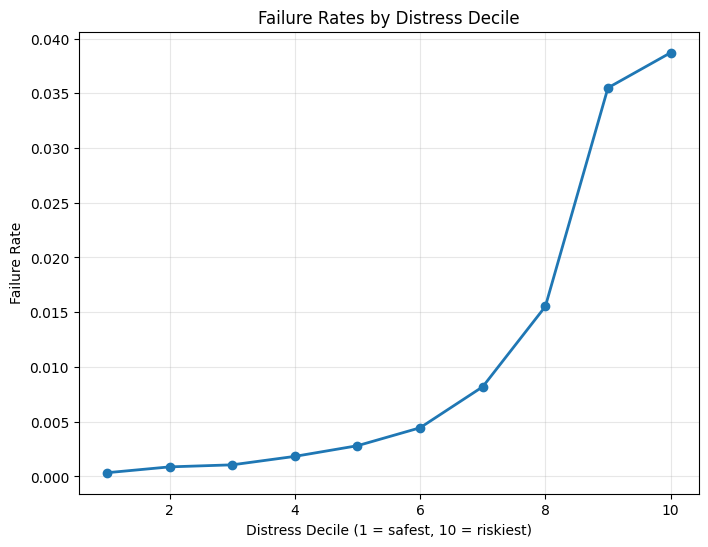

In [19]:
# get failure rate table again (if not already saved)
failure_by_decile = (
    panel.group_by("distress_decile")
         .agg([
             (pl.col("FAIL_12M").mean()).alias("failure_rate"),
             pl.len().alias("n")
         ])
         .sort("distress_decile")
         .to_pandas()
)

# plot
plt.figure(figsize=(8,6))
plt.plot(failure_by_decile["distress_decile"],
         failure_by_decile["failure_rate"],
         marker="o", linestyle="-", linewidth=2)

plt.xlabel("Distress Decile (1 = safest, 10 = riskiest)")
plt.ylabel("Failure Rate")
plt.title("Failure Rates by Distress Decile")
plt.grid(True, alpha=0.3)
plt.show()

AUC: 0.907


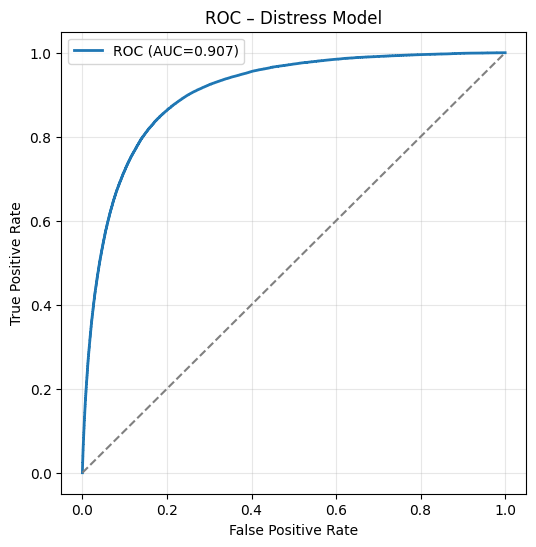

In [20]:
# =========================================================
# 21) ROC curve + AUC (manual, no sklearn)
# =========================================================
import numpy as np
import matplotlib.pyplot as plt

# grab labels + scores, drop nulls
roc_df = (
    panel
    .select(["FAIL_12M", "FAIL_PROB_12M"])
    .drop_nulls()
    .to_pandas()
)

y_true = roc_df["FAIL_12M"].astype(int).values
y_score = roc_df["FAIL_PROB_12M"].values

# sort by predicted score descending
order = np.argsort(-y_score)
y_true = y_true[order]
y_score = y_score[order]

# cumulative counts
tp = np.cumsum(y_true)
fp = np.cumsum(1 - y_true)

tp_rate = tp / tp[-1]
fp_rate = fp / fp[-1]

# trapezoidal auc
auc = np.trapezoid(tp_rate, fp_rate)
print(f"AUC: {auc:.3f}")

# plot ROC
plt.figure(figsize=(6,6))
plt.plot(fp_rate, tp_rate, lw=2, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC – Distress Model")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()